In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, spearmanr

In [ ]:
train_ratings = pd.read_csv('../data/train/train_ratings.csv', sep=',')


In [11]:
def analyze_movie_popularity_hypothesis(train_ratings, popularity_threshold=0.75):
    """
    영화 인기도와 사용자 시청 패턴의 관계를 분석하는 함수
    
    Parameters:
    train_ratings: DataFrame with columns 'user', 'item', 'rating'
    popularity_threshold: float, percentile for defining popular movies
    
    Returns:
    dict containing analysis results
    """
    # 1. 기본 인기도 분석
    item_counts = train_ratings.groupby('item').size().reset_index(name='interaction_count')
    popular_threshold = item_counts['interaction_count'].quantile(popularity_threshold)
    popular_items = item_counts[item_counts['interaction_count'] >= popular_threshold]['item']
    
    # 2. 사용자별 시청 패턴 분석
    user_viewing_patterns = train_ratings.groupby('user').agg({
        'item': 'count',  # 총 시청 영화 수
    }).reset_index()
    
    # 3. 사용자별 인기 영화 시청 비율 계산
    popular_user_movies = train_ratings.copy()
    popular_user_movies['is_popular'] = popular_user_movies['item'].isin(popular_items).astype(int)
    user_popular_ratio = popular_user_movies.groupby('user').agg({
        'is_popular': 'mean',  # 인기 영화 비율
        'item': 'count'  # 총 시청 수
    }).reset_index()
    user_popular_ratio.columns = ['user', 'popular_ratio', 'total_movies']
    
    # 4. 상관관계 분석: 총 시청 수와 인기 영화 비율
    correlation = user_popular_ratio['popular_ratio'].corr(user_popular_ratio['total_movies'])
    
    # 5. 사용자 그룹별 평균 시청 수 분석
    user_popular_ratio['user_group'] = pd.cut(
        user_popular_ratio['popular_ratio'],
        bins=[-np.inf, 0.2, 0.4, 0.6, 0.8, np.inf],
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
    )
    
    group_stats = user_popular_ratio.groupby('user_group').agg({
        'user': 'count',  # 그룹별 사용자 수
        'total_movies': ['mean', 'median', 'std'],  # 그룹별 시청 통계
        'popular_ratio': 'mean'  # 그룹별 평균 인기 영화 비율
    }).round(2)
    
    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 인기 영화 비율 분포
    sns.histplot(data=user_popular_ratio, x='popular_ratio', bins=30, ax=ax1)
    ax1.set_title('Distribution of Popular Movie Ratios')
    ax1.set_xlabel('Ratio of Popular Movies Watched')
    ax1.set_ylabel('Number of Users')
    
    # 산점도: 총 시청 수 vs 인기 영화 비율
    sns.scatterplot(
        data=user_popular_ratio,
        x='total_movies',
        y='popular_ratio',
        alpha=0.5,
        ax=ax2
    )
    ax2.set_title(f'Total Movies vs Popular Ratio\nCorrelation: {correlation:.2f}')
    ax2.set_xlabel('Total Movies Watched')
    ax2.set_ylabel('Popular Movie Ratio')
    
    plt.tight_layout()
    
    return {
        'popular_threshold': popular_threshold,
        'num_popular_movies': len(popular_items),
        'correlation': correlation,
        'group_stats': group_stats,
        'user_popular_ratio': user_popular_ratio
    }

/tmp/ipykernel_331041/1627408974.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = user_popular_ratio.groupby('user_group').agg({


             user total_movies                popular_ratio
            count         mean median     std          mean
user_group                                                 
Very Low        5        40.80   38.0   20.58          0.16
Low           113       322.17  155.0  409.65          0.35
Medium       1141       305.61  176.0  310.05          0.53
High         6566       236.25  164.0  206.51          0.73
Very High   23535       136.73  105.0   96.63          0.91
총 시청 수와 인기 영화 비율의 상관관계: -0.37


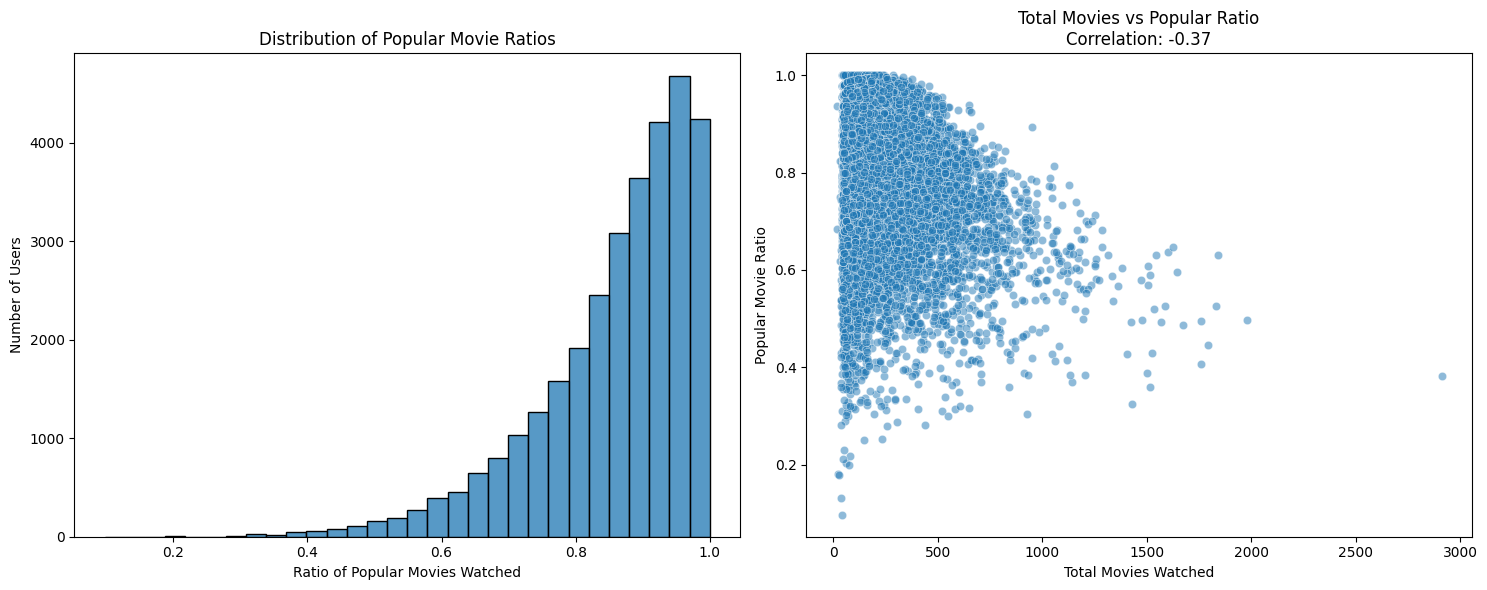

In [12]:
results = analyze_movie_popularity_hypothesis(train_ratings)

# 그룹별 통계 확인
print(results['group_stats'])

# 상관관계 확인
print(f"총 시청 수와 인기 영화 비율의 상관관계: {results['correlation']:.2f}")


In [ ]:
def create_user_popularity_ratio(train_ratings, popularity_threshold=0.75):
    """
    사용자별 인기 영화 시청 비율을 계산하는 함수
    
    Parameters:
    train_ratings: DataFrame with columns 'user', 'item', 'rating'
    popularity_threshold: float, percentile for defining popular movies (default: 0.75)
    
    Returns:
    DataFrame containing user_popular_ratio with columns:
    - user: 사용자 ID
    - popular_ratio: 인기 영화 시청 비율
    - total_movies: 총 시청 영화 수
    - user_group: 인기 영화 비율에 따른 그룹
    """
    # 1. 영화별 시청 횟수 계산
    item_counts = train_ratings.groupby('item').size().reset_index(name='interaction_count')
    
    # 2. 인기 영화 기준선 설정 및 인기 영화 식별
    popular_threshold = item_counts['interaction_count'].quantile(popularity_threshold)
    popular_items = item_counts[item_counts['interaction_count'] >= popular_threshold]['item']
    
    # 3. 사용자별 인기 영화 시청 비율 계산
    popular_user_movies = train_ratings.copy()
    popular_user_movies['is_popular'] = popular_user_movies['item'].isin(popular_items).astype(int)
    
    user_popular_ratio = popular_user_movies.groupby('user').agg({
        'is_popular': 'mean',  # 인기 영화 비율
        'item': 'count'  # 총 시청 수
    }).reset_index()
    
    user_popular_ratio.columns = ['user', 'popular_ratio', 'total_movies']
    
    # 4. 인기 영화 비율에 따른 그룹 분류
    user_popular_ratio['user_group'] = pd.cut(
        user_popular_ratio['popular_ratio'],
        bins=[-np.inf, 0.2, 0.4, 0.6, 0.8, np.inf],
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
    )
    
    return user_popular_ratio


In [ ]:
user_popular_ratio = create_user_popularity_ratio(train_ratings)

In [ ]:
def detailed_statistical_analysis(user_popular_ratio):
    """
    영화 시청 패턴에 대한 상세 통계 분석을 수행하는 함수
    
    Parameters:
    user_popular_ratio: DataFrame with columns ['user', 'popular_ratio', 'total_movies', 'user_group']
    
    Returns:
    dict containing detailed statistical analysis results
    """
    results = {}
    
    # 1. 스피어만 상관 계수 (비선형 관계도 포착 가능)
    spearman_corr, p_value = spearmanr(user_popular_ratio['total_movies'], 
                                      user_popular_ratio['popular_ratio'])
    results['spearman'] = {
        'correlation': round(spearman_corr, 3),
        'p_value': p_value
    }
    
    # 2. 그룹간 시청 수 차이의 통계적 유의성 (Kruskal-Wallis H-test)
    groups_data = [group['total_movies'].values 
                  for name, group in user_popular_ratio.groupby('user_group')]
    h_stat, h_p_value = stats.kruskal(*groups_data)
    results['kruskal'] = {
        'h_statistic': round(h_stat, 3),
        'p_value': h_p_value
    }
    
    # 3. 효과 크기 계산 (Cohen's d between Very High and Low groups)
    very_high = user_popular_ratio[user_popular_ratio['user_group'] == 'Very High']['total_movies']
    low = user_popular_ratio[user_popular_ratio['user_group'] == 'Low']['total_movies']
    
    cohens_d = (very_high.mean() - low.mean()) / np.sqrt(
        ((very_high.std() ** 2) + (low.std() ** 2)) / 2
    )
    results['effect_size'] = round(cohens_d, 3)
    
    # 4. 기술 통계량 계산
    descriptive_stats = user_popular_ratio.groupby('user_group').agg({
        'total_movies': ['count', 'mean', 'std', 'median', 
                        lambda x: stats.sem(x)]  # Standard Error of Mean
    }).round(2)
    
    # 신뢰구간 계산 및 추가
    ci_95 = {}
    for group in user_popular_ratio['user_group'].unique():
        data = user_popular_ratio[user_popular_ratio['user_group'] == group]['total_movies']
        ci = stats.t.interval(0.95, len(data)-1, 
                            loc=np.mean(data), 
                            scale=stats.sem(data))
        ci_95[group] = [round(ci[0], 2), round(ci[1], 2)]
    
    descriptive_stats.columns = ['count', 'mean', 'std', 'median', 'sem']
    descriptive_stats['ci_95'] = pd.Series(ci_95)
    
    results['descriptive_stats'] = descriptive_stats
    
    return results

# 결과 출력을 위한 함수
def print_statistical_results(results):
    """
    통계 분석 결과를 보기 좋게 출력하는 함수
    """
    print("1. 상관관계 분석:")
    print(f"스피어만 상관계수: {results['spearman']['correlation']}")
    print(f"p-value: {results['spearman']['p_value']:.10f}")
    print("\n2. 그룹간 차이 검정 (Kruskal-Wallis):")
    print(f"H-통계량: {results['kruskal']['h_statistic']}")
    print(f"p-value: {results['kruskal']['p_value']:.10f}")
    print("\n3. 효과 크기:")
    print(f"Cohen's d (Very High vs Low): {results['effect_size']}")
    print("\n4. 그룹별 기술 통계:")
    print(results['descriptive_stats'])

In [26]:
# 분석 실행
results = detailed_statistical_analysis(user_popular_ratio)

# 결과 출력
print_statistical_results(results)

1. 상관관계 분석:
스피어만 상관계수: -0.284
p-value: 0.0000000000

2. 그룹간 차이 검정 (Kruskal-Wallis):
H-통계량: 1522.82
p-value: 0.0000000000

3. 효과 크기:
Cohen's d (Very High vs Low): -0.623

4. 그룹별 기술 통계:
            count    mean     std  median    sem             ci_95
user_group                                                        
Very Low        5   40.80   20.58    38.0   9.21    [15.24, 66.36]
Low           113  322.17  409.65   155.0  38.54  [245.81, 398.52]
Medium       1141  305.61  310.05   176.0   9.18   [287.6, 323.61]
High         6566  236.25  206.51   164.0   2.55  [231.25, 241.24]
Very High   23535  136.73   96.63   105.0   0.63   [135.5, 137.97]


/tmp/ipykernel_331041/780219743.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in user_popular_ratio.groupby('user_group')]
/tmp/ipykernel_331041/780219743.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  descriptive_stats = user_popular_ratio.groupby('user_group').agg({
